In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
from datetime import datetime # Import datetime to get current date

# 1. Settings
STOCK = 'NVDA'  # The stock we want to analyze
START_DATE = '2020-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d') # Set END_DATE to current date

print(f"--- Analyzing {STOCK} Factors ---")

# 2. Get Data
# A. Get Stock Returns from Yahoo Finance
# With auto_adjust=True (default), 'Close' column contains the adjusted prices
stock_data = yf.download(STOCK, start=START_DATE, end=END_DATE)['Close']
stock_returns = stock_data.resample('M').last().pct_change().dropna()

# The kernel state indicates stock_returns is a DataFrame with a column named STOCK ('NVDA').
# We need to rename this column to 'Stock_Returns' for subsequent steps.
stock_returns = stock_returns.rename(columns={STOCK: "Stock_Returns"})

# Convert the Timestamp index to Period index for proper merging with Fama-French data
stock_returns.index = stock_returns.index.to_period('M')

# B. Get Fama-French Factors (Market, Size, Value)
# 'F-F_Research_Data_Factors' is the standard dataset ID
ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE)[0]
# Convert Fama-French from percentage (e.g., 5.0) to decimal (0.05)
ff_data = ff_data / 100

# 3. Merge Data
# We subtract the Risk-Free Rate (RF) to get "Excess Returns"
data = pd.merge(stock_returns, ff_data, left_index=True, right_index=True)
data['Excess_Returns'] = data['Stock_Returns'] - data['RF']

# 4. The Regression (OLS)
# Formula: (Return - RF) = Alpha + b1(Mkt-RF) + b2(SMB) + b3(HML)
Y = data['Excess_Returns']
X = data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X) # Adds the intercept (Alpha)

model = sm.OLS(Y, X).fit()

# 5. Output
print(model.summary())

# 6. Simple Interpretation
alpha = model.params['const'] * 12 # Annualized Alpha
beta = model.params['Mkt-RF']
print(f"\nRESULTS FOR {STOCK}:")
print(f"Alpha (Annualized): {alpha:.2%}")
print(f"Market Beta: {beta:.2f}")
if model.pvalues['const'] < 0.05:
    print("-> Alpha is Statistically Significant (Real Skill/Outperformance)")
else:
    print("-> Alpha is NOT Significant (Performance explained by risk factors)")

--- Analyzing NVDA Factors ---


/tmp/ipython-input-2999542316.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(STOCK, start=START_DATE, end=END_DATE)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2999542316.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_returns = stock_data.resample('M').last().pct_change().dropna()


                            OLS Regression Results                            
Dep. Variable:         Excess_Returns   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     25.11
Date:                Sat, 17 Jan 2026   Prob (F-statistic):           5.92e-11
Time:                        17:18:45   Log-Likelihood:                 64.875
No. Observations:                  70   AIC:                            -121.8
Df Residuals:                      66   BIC:                            -112.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394      0.012      3.238      0.0

/tmp/ipython-input-2999542316.py:29: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE)[0]
/tmp/ipython-input-2999542316.py:29: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=START_DATE, end=END_DATE)[0]


In [2]:
# @title {"display-mode":"form"}
from IPython.display import HTML

display(HTML("""
<div style="font-family: sans-serif; line-height: 1.5;">
    <h3>Advanced Four-in-One Regression Diagnostic Plots</h3>

    <p>This set of four plots provides a comprehensive diagnostic analysis of the OLS regression model. Each plot addresses a specific assumption or potential issue in the model.</p>

    <ol>
        <li><strong>Residuals vs. Fitted:</strong> Checks for linearity and homoscedasticity.</li>
        <li><strong>Normal Q-Q:</strong> Checks for the normality of residuals.</li>
        <li><strong>Scale-Location:</strong> Another check for homoscedasticity, plotting the square root of standardized residuals.</li>
        <li><strong>Residuals vs. Leverage:</strong> Identifies influential points that may have a large impact on the regression coefficients.</li>
    </ol>
</div>
"""))

<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3935537233.py:45: SyntaxWarning: invalid escape sequence '\s'
  axes[1, 0].set_ylabel('$\sqrt{|\text{Standardized Residuals}|}$', fontsize=12)


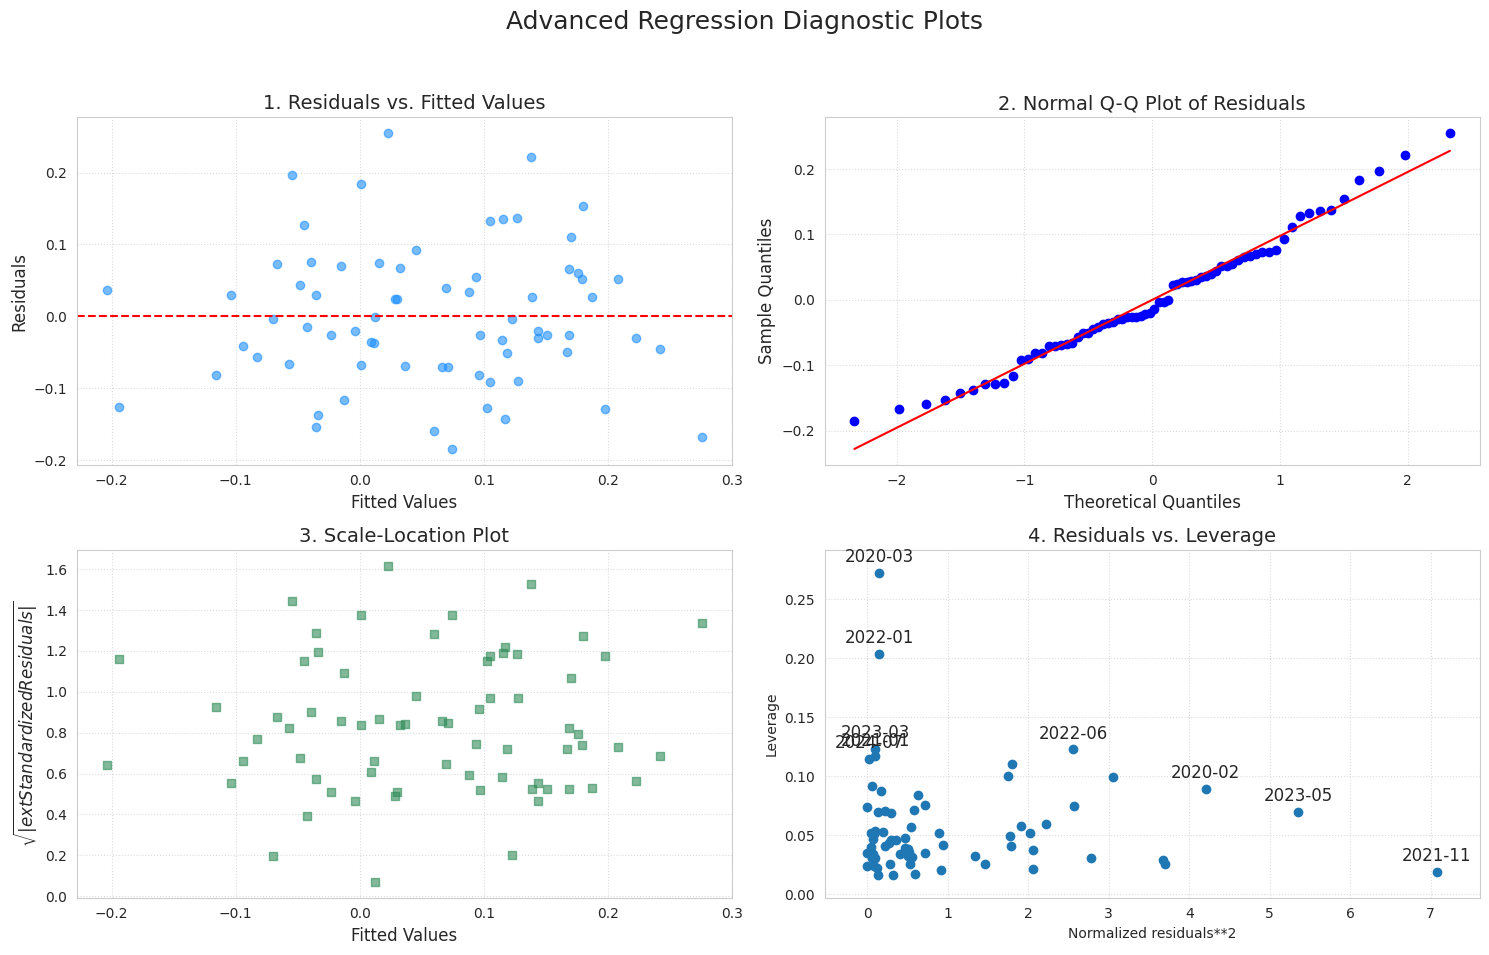

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np  # Added this import

sns.set_style('whitegrid') # Apply a neat seaborn style

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Advanced Regression Diagnostic Plots', fontsize=18)

# 1. Residuals vs Fitted Plot
# This is already provided by statsmodels' plot_regress_exog
# However, to maintain a consistent 'four-in-one' style, we can plot manually or use specific statsmodels helper functions

# For simplicity and consistency with the previous manual plots, we'll recreate the residuals vs fitted plot
# and then use statsmodels' influence plots for the others.

# Residuals vs. Fitted Values
residuals = model.resid
fitted_vals = model.fittedvalues
axes[0, 0].scatter(fitted_vals, residuals, alpha=0.6, color='dodgerblue', marker='o')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0, 0].set_title('1. Residuals vs. Fitted Values', fontsize=14)
axes[0, 0].set_xlabel('Fitted Values', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].grid(True, linestyle=':', alpha=0.7)

# 2. Normal Q-Q Plot
# Requires stats.probplot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('2. Normal Q-Q Plot of Residuals', fontsize=14)
axes[0, 1].set_xlabel('Theoretical Quantiles', fontsize=12)
axes[0, 1].set_ylabel('Sample Quantiles', fontsize=12)
axes[0, 1].grid(True, linestyle=':', alpha=0.7)

# 3. Scale-Location Plot (Spread-Location Plot)
# Plots sqrt(|standardized residuals|) vs fitted values to check homoscedasticity
# We'll use statsmodels' get_influence for standardized residuals
standardized_residuals = model.get_influence().resid_studentized_internal
axes[1, 0].scatter(fitted_vals, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, color='seagreen', marker='s')
axes[1, 0].set_title('3. Scale-Location Plot', fontsize=14)
axes[1, 0].set_xlabel('Fitted Values', fontsize=12)
axes[1, 0].set_ylabel('$\sqrt{|\text{Standardized Residuals}|}$', fontsize=12)
axes[1, 0].grid(True, linestyle=':', alpha=0.7)

# 4. Residuals vs Leverage Plot
# Identifies influential observations
from statsmodels.graphics.regressionplots import plot_leverage_resid2
plot_leverage_resid2(model, ax=axes[1, 1])
axes[1, 1].set_title('4. Residuals vs. Leverage', fontsize=14)
axes[1, 1].grid(True, linestyle=':', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [4]:
# @title {"display-mode":"both"}
from IPython.display import HTML

display(HTML("""
<div style="font-family: sans-serif; line-height: 1.5; border: 1px solid #ccc; border-radius: 5px; padding: 15px; margin: 10px 0;">
    <h3 style="margin-top: 0;">Multicollinearity Check: Variance Inflation Factor (VIF)</h3>

    <p>VIF measures how much the variance of an estimated regression coefficient is inflated due to multicollinearity. A VIF value greater than 5 or 10 is often a cause for concern, indicating high multicollinearity.</p>
</div>
"""))

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Drop the constant from X when calculating VIF
X_no_const = X.drop('const', axis=1)

vif_data = pd.DataFrame()
vif_data['feature'] = X_no_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]

print("\n--- Multicollinearity Check (VIF) ---")
print(vif_data)

# Interpretation
print("\nInterpretation:")
for index, row in vif_data.iterrows():
    if row['VIF'] > 10:
        print(f"-> {row['feature']} has a high VIF ({row['VIF']:.2f}), indicating significant multicollinearity. This might make its coefficient estimate unstable.")
    elif row['VIF'] > 5:
        print(f"-> {row['feature']} has a moderately high VIF ({row['VIF']:.2f}), suggesting potential multicollinearity. Monitor its impact.")
    else:
        print(f"-> {row['feature']} has a low VIF ({row['VIF']:.2f}), indicating no significant multicollinearity concerns.")


--- Multicollinearity Check (VIF) ---
  feature       VIF
0  Mkt-RF  1.101935
1     SMB  1.106377
2     HML  1.004361

Interpretation:
-> Mkt-RF has a low VIF (1.10), indicating no significant multicollinearity concerns.
-> SMB has a low VIF (1.11), indicating no significant multicollinearity concerns.
-> HML has a low VIF (1.00), indicating no significant multicollinearity concerns.


In [6]:
# @title {"display-mode":"form"}
from IPython.display import HTML

display(HTML("""
<div style="font-family: sans-serif; line-height: 1.5; border: 1px solid #ccc; border-radius: 5px; padding: 15px; margin: 10px 0;">
    <h3 style="margin-top: 0;">Autocorrelation Check: Durbin-Watson Statistic</h3>

    <p>The Durbin-Watson statistic tests for the presence of autocorrelation in the residuals. A value close to 2 suggests no autocorrelation. Values significantly below 2 (e.g., < 1.5) indicate positive autocorrelation, while values significantly above 2 (e.g., > 2.5) suggest negative autocorrelation. Autocorrelation can lead to underestimated standard errors and invalid statistical tests.</p>
</div>
"""))

In [7]:
from statsmodels.stats.stattools import durbin_watson

dw_statistic = durbin_watson(model.resid)

print("\n--- Autocorrelation Check (Durbin-Watson) ---")
print(f"Durbin-Watson Statistic: {dw_statistic:.3f}")

# Interpretation
print("\nInterpretation:")
if 1.5 < dw_statistic < 2.5:
    print("-> The Durbin-Watson statistic is close to 2, suggesting no significant positive or negative autocorrelation.")
elif dw_statistic <= 1.5:
    print("-> The Durbin-Watson statistic is less than or equal to 1.5, indicating possible positive autocorrelation. This may suggest that residuals are correlated over time.")
else: # dw_statistic >= 2.5
    print("-> The Durbin-Watson statistic is greater than or equal to 2.5, indicating possible negative autocorrelation. This is less common but can occur.")


--- Autocorrelation Check (Durbin-Watson) ---
Durbin-Watson Statistic: 1.943

Interpretation:
-> The Durbin-Watson statistic is close to 2, suggesting no significant positive or negative autocorrelation.


In [9]:
# @title
from IPython.display import HTML

display(HTML("""
<div style="font-family: sans-serif; line-height: 1.5; border: 1px solid #ccc; border-radius: 5px; padding: 15px; margin: 10px 0;">
    <h3 style="margin-top: 0;">Histogram of Residuals</h3>

    <p>This histogram provides another visual check for the normality of the residuals. For normally distributed residuals, the histogram should approximate a bell-shaped curve.</p>
</div>
"""))

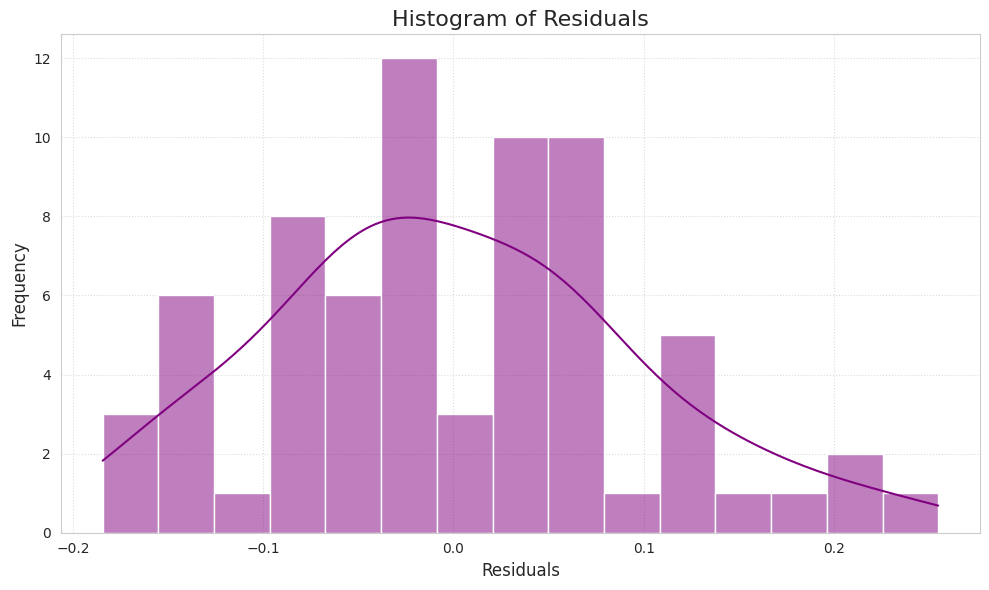

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid') # Apply a neat seaborn style

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=15) # kde=True adds a kernel density estimate
plt.title('Histogram of Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()